# Comparación entre algoritmos Dijkstra y A*

In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import heapq
import sys
import random
import math
import time
import numpy as np
import warnings
warnings.filterwarnings("ignore")

## Clase grafo y clase vertice

In [3]:
class Vertex:
    def __init__(self, node,lon,lat,cont):
      rand = random.randrange(9000,100000)
      self.id = node
      self.adjacent = {} #forma -> tipo nodo vecino: peso 
      # Distancia infinito para todos los nodos (infinito es un random grande)
      self.distance = rand
      self.distanceG = rand
      self.distanceF = rand
      # Todos los nodos inician como no visitados    
      self.visited = False  
      # prev
      self.previous = None
      #longitud y latitud
      self.longitud = lon
      self.latitud = lat
      self.cont = cont #identificador unico para cada vertice (a parte del id)

    def agregar_vecino(self, neighbor, weight=0):
      self.adjacent[neighbor] = weight

    def obtener_conexiones(self): 
      return self.adjacent.keys() #devuelve los vecinos de tipo vertice (no numerico) 

    def obtener_id(self):
      return self.id

    def obtener_peso(self, neighbor):
      return self.adjacent[neighbor]

    def agregar_distancia(self, dist):
      self.distance = dist

    def obtener_distancia(self):
      return self.distance

    def agregar_distanciaG(self, dist):
      self.distanceG = dist

    def obtener_distanciaG(self):
      return self.distanceG

    def agregar_distanciaF(self, dist):
      self.distanceF = dist

    def obtener_distanciaF(self):
      return self.distanceF

    def obtener_lon(self):
      return self.longitud

    def obtener_lat(self):
      return self.latitud

    def agregar_previous(self, prev):
      self.previous = prev

    def visitado(self):
      self.visited = True

    def __str__(self):
      return str(self.id) + ' adjacent: ' + str([x.id for x in self.adjacent])

class Estruc:
  def __init__(self):
    self.camino = []
    self.reemplazo = []
  def obtener_camino(self):
    return self.camino
  def obtener_reemplazo(self):
    return self.reemplazo

class Graph:
  def __init__(self):
    self.vert_dict = {}
    self.num_vertices = 0

  def __iter__(self):
    return iter(self.vert_dict.values())

  def agregar_vertice(self, node,lon,lat,cont):
    self.num_vertices = self.num_vertices + 1
    new_vertex = Vertex(node,lon,lat,cont)
    self.vert_dict[node] = new_vertex
    return new_vertex

  def obtener_vertice(self, n):
    if n in self.vert_dict:
      return self.vert_dict[n]
    else:
      return None

  def agregar_arista(self, frm, to, cost = 0):
    if frm not in self.vert_dict: #nunca llega a este caso
      self.agregar_vertice(frm)
    if to not in self.vert_dict: #nunca llega a este caso
      self.agregar_vertice(to)

    self.vert_dict[frm].agregar_vecino(self.vert_dict[to], cost)
    #self.vert_dict[to].agregar_vecino(self.vert_dict[frm], cost) ############

  def obtener_vertices(self):
    return self.vert_dict.keys()
  
  def obtener_vertices_nodes(self):
    return self.vert_dict.values()

  def agregar_previous(self, u):
    self.previous = u

  def obtener_previous(self, u):
    return self.previous

  def vnsEstructuras(self): #Solo usar cuando el grafo ya tenga todos los nodos y aristas.
    estruc1 = Estruc()
    estruc2 = Estruc()
    for s in self.vert_dict.values():
      for v in s.obtener_conexiones():
        for v2 in s.obtener_conexiones():
          if v2 != v and v in v2.obtener_conexiones():
            if(s.obtener_peso(v2) + v2.obtener_peso(v) > s.obtener_peso(v)):
              estruc2.camino.append([(s,v2),(v2,v)])
              estruc2.reemplazo.append((s,v))
            else:
              estruc1.camino.append((s,v))
              estruc1.reemplazo.append([(s,v2),(v2,v)])
    return estruc1, estruc2

# AG

## VNS para cada individuo

In [4]:
def vns(individuo, estruc1, estruc2):
    k = 0
    estructuras = [estruc1, estruc2]
    while (k < 2):
        i = 0
        while (i < len(individuo) - k - 1):
            if(k == 0):
                if((individuo[i], individuo[i+1]) in estructuras[k].obtener_camino()):
                    pos = estructuras[k].obtener_camino().index((individuo[i],individuo[i+1]))
                    individuo[i:i+2] = (estructuras[k].obtener_reemplazo()[pos][0][0], estructuras[k].obtener_reemplazo()[pos][0][1], estructuras[k].obtener_reemplazo()[pos][1][1])
                    i = 0
                else: i = i+1
            if(k == 1):
                if([(individuo[i], individuo[i+1]),(individuo[i+1], individuo[i+2])] in estructuras[k].obtener_camino()):
                    pos = estructuras[k].obtener_camino().index([(individuo[i], individuo[i+1]),(individuo[i+1], individuo[i+2])])
                    individuo.pop(i+1)
                    i = 0
                else: i = i+1     
        k = k + 1
    return individuo

In [5]:
#N = Número de individuos
# G = Grafo
#s = nodo inicial
#t = nodo final
def esBucle(nodo):
  banderas = []
  adyacentes = nodo.obtener_conexiones()
  for adyacente in adyacentes:
    if adyacente.visited == True:
      banderas.append(True)
    else: banderas.append(False)
  if(len(banderas) == 1): return banderas[0]
  if(len(banderas) == 0): return True #########
  for i in range(len(banderas) - 1):
    if(i == 0):
      respuesta = banderas[i] and banderas[i+1]
    else:
      respuesta = respuesta and banderas[i+1]
  return respuesta

def poblacionInicial(N, s, t, G):
    poblacion = []
    for i in range(N):
        actual = s
        individuo = []
        individuo.insert(0,s)
        actual.visited = True
        while(actual != t):
            adyacentes = list(actual.obtener_conexiones())
            nodo = random.choice(list(adyacentes))
            if(esBucle(nodo) and nodo != t):
                nodo.visited = True
            if(nodo.visited == False):
                if(actual not in individuo):
                    individuo.append(actual)
                individuo.append(nodo)
                nodo.visited = True
                actual = nodo
            if(esBucle(actual) and actual != t):
                actual.visited = True
                actual = individuo.pop()
        poblacion.append(individuo)
        for vertice in list(G.obtener_vertices_nodes()):
            vertice.visited = False
    return poblacion

def f(x):
    return x
def fitness(individuo):
    suma = 0
    for i in range(len(individuo) - 1):
        suma = suma + individuo[i].obtener_peso(individuo[i+1])
    return suma

def crossover(x1, x2, CROSSOVER_RATIO):
    if(random.random()<= CROSSOVER_RATIO):
        a = x1.copy()
        b = x2.copy()
        inicio = x1[0]
        final = x1[-1]
        cortes = []
        for i in range(len(x1)):
            if x1[i] in x2 and x1[i] is not inicio and x1[i] is not final:
                corte1 = i + 1
                for j in range(len(x2)):
                    if x2[j] == x1[corte1 - 1]:
                        corte2 = j + 1
                        cortes.append((corte1,corte2))
        c = random.choice(cortes)
        aux = x1.copy()
        a[c[0]:] = b[c[1]:]
        b[c[1]:] = a[c[0]:]
        return a,b
    return x1,x2

def mutation(x, estruc1, estruc2, MUTATION_RATIO):
  if(random.random()<= MUTATION_RATIO):
    x = vns(x.copy(), estruc1, estruc2)
    return x
  return x

def operaciones_seleccion_proporcional(cadbin, best, num_padres, estruc1, estruc2, CROSSOVER_RATE,MUTATION_RATE):
  #c = np.ndarray([],dtype=object) #padres
  c = []
  h = [] #hijos
  prob = []
  #Llevando los valores más bajos arriba, y los más altos abajo, ya que lo que quiero es minimizar
  F = []
  for i in range(len(best)):
    F.append(max(best) - best[i] + 1e-6)
  for i in range(len(F)):
    prob.append((F[i]+100)/(sum(F)+(100*len(F))))

  #num_padres siempre es par
  rnd_indices = np.random.choice(len(cadbin.copy()),num_padres,replace=False, p=prob.copy())
  #rnd_indices = np.random.choice(len(cadbin),num_padres,replace=False)
  for z in range(num_padres):
    c.append(cadbin[rnd_indices[z]])
  indice2 = 0
  for i in range(int(num_padres/2)):
    c1 , c2 = crossover(c[indice2].copy(), c[indice2+1].copy(),CROSSOVER_RATE)
    h.append(mutation(c1.copy(), estruc1, estruc2, MUTATION_RATE))
    h.append(mutation(c2.copy(), estruc1, estruc2, MUTATION_RATE))
    #h.append(c1)
    #h.append(c2)
    indice = indice2 - 1
    for k in range(2): #Siempre será 2, pues evaluamos a los dos nuevos hijos
      cadbin.append(h[indice+1])
      indice = indice+1
    indice2 = indice2+2
  return cadbin

def select_elitista(cadbin, POBLACION): #Se seleccionan las POBLACION mejores soluciones para la siguiente generacion
  pesos = []
  pesos_ord = []
  next_generation = []
  for i in range(len(cadbin)):
    pesos.append(fitness(cadbin[i]))
    pesos_ord.append(fitness(cadbin[i]))
  pesos_ord.sort()
  for i in range(len(cadbin)):
    pos = pesos.index(pesos_ord[i])
    next_generation.append(cadbin[pos])
  return next_generation[0:POBLACION]

In [6]:
# cadbin es el conjunto de donde seleccionarás
# n es la cantidad de individuos a seleccionar
def girar_ruleta(cadbin, best):
    b = best.copy()
    f = np.array(best)
    f = (max(best) - f + 1)
    f = f/sum(f)
    f.sort()
    F = []
    suma = 0
    for i in range(len(best)):
        suma = suma + f[i]
        F.append(suma)
    b.sort(reverse=True)        
    r = random.random()
    for i in range(len(best)):
        if(r <= F[i]):
            pos = best.index(b[i])
            return cadbin.copy()[pos]
    
def select_ruleta(cadbin, best, n):
    next_generation = []
    for i in range(n):
        next_generation.append(girar_ruleta(cadbin, best))
    return next_generation

## Algoritmo genético para el camino mínimo

In [7]:
def AG_caminoMinimo(N,GENERACIONES,CROSSOVER_RATE,MUTATION_RATE, num_padres, q, s, t, g, seleccion):
    #online, offline, on, off = [], [], [], []
    estruc1, estruc2 = g.vnsEstructuras()
    cadbin = poblacionInicial(N,g.obtener_vertice(s), g.obtener_vertice(t),g)
    POBLACION = N
    mejores_por_generacion = []
    mejor = []
    for j in range(N):
        #cadbin[j] = vns(cadbin[j].copy(), estruc1, estruc2) ## primer uso de vns
        mejor.append(fitness(cadbin[j]))
    mejores_por_generacion.append(min(mejor))
    ##Inicio del algoritmo
    for i in range(GENERACIONES):
        best = []
        mejor = []
        for j  in range(N):
            best.append(fitness(cadbin[j]))
        cadbin = operaciones_seleccion_proporcional(cadbin.copy(), best, num_padres, estruc1, estruc2, CROSSOVER_RATE, MUTATION_RATE)
        N = len(cadbin)
        best = []
        for j in range(N):
            best.append(fitness(cadbin[j]))
        if(seleccion == "ELITISTA"):
            cadbin = select_elitista(cadbin.copy(), POBLACION)
        if(seleccion == "RULETA"):
            cadbin = select_ruleta(cadbin.copy(), best, POBLACION)
        N = len(cadbin)
        for j in range(N):
            mejor.append(fitness(cadbin[j]))
        mejores_por_generacion.append(min(mejor))

    respuestas = []
    for i in range(len(cadbin)):
        respuestas.append(fitness(cadbin[i]))
    print("mejor fitness final: ", min(respuestas))
    return min(mejores_por_generacion)

# Algoritmo Dijkstra

In [8]:
def dijkstra(aGraph, start, target):
    '''Algoritmo de Dijkstra'''
    # distancia del nodo inicial = 0
    start.agregar_distancia(0)

    # se colocarán todas las tuplas (distancia,vertice) en una cola de prioridad (Q)
    Q = []
    dic = {} #diccionario donde almaceno id,vertice
    nodos_expandidos = 0
    for v in aGraph:
        dic[v.cont] = v
        Q.append((v.obtener_distancia(),v.cont))
    heapq.heapify(Q)
    #nodos_open = []
    while len(Q):
        nodos_expandidos +=1
        # Hacemos pop a la tupla (distancia, vertice) con menor distancia de Q
        uv = heapq.heappop(Q) #Se asigna y se elimina u de Q
        #nodos_open.append(uv)
        u = dic.get(uv[1]) #Se obtiene el vértice
        u.visitado()
        #Sale del algoritmo de Dijkstra
        if(u.id == target.id):
            u_copia = u
            camino = []
            camino.append(u_copia.id)
            if(u_copia.previous):
                while(u_copia.previous):
                    camino.append(u_copia.previous.id)
                    u_copia = u_copia.previous
                #print(u.obtener_distancia(), camino[::-1])
                #print(nodos_open)
                print("longitud camino mínimo: ",len(camino))
                #print("vértices expandidos: ",nodos_expandidos)
                #eficiencia = len(camino)/nodos_expandidos
                #print("Eficiencia: ", eficiencia)
                return u.obtener_distancia(), camino[::-1]

        # Para cada vertice vecino v de u :
        for v in u.adjacent:
            if v.visited:
                continue
            new_dist = u.obtener_distancia() + u.obtener_peso(v)
            
            if new_dist < v.obtener_distancia():
                v.agregar_distancia(new_dist)
                v.agregar_previous(u)  

        #Refresh de la cola de prioridad
        # 1. Hacemos pop de todos los items
        while len(Q):
            heapq.heappop(Q)
        # 2. Actualizamos todos los vértices no visitados del grafo
        dic = {} #diccionario donde almaceno id,vertice
        for v in aGraph:
            if not v.visited:
                dic[v.cont] = v
                Q.append((v.obtener_distancia(),v.cont))
        heapq.heapify(Q)

# Algoritmo A*

In [9]:
def h(x1,y1,x2,y2):
  '''Distancia Euclidea'''
  distance = ((x2 - x1)**2 + (y2 - y1)**2)**(1/2)
  return distance * 6371 *(math.pi/180)*1000

In [10]:
def AStar(aGraph, start, target):
    '''Algoritmo de A*'''
    # distancia del nodo inicial = 0
    start.agregar_distancia(0)
    start.agregar_distanciaG(0)
    start.agregar_distanciaF(h(start.longitud, start.latitud, target.longitud, target.latitud))
    # se colocarán todas las tuplas (distancia,vertice) en una cola de prioridad (Q)
    Q = []
    nodos_expandidos = 0
    dic = {} #diccionario donde almaceno id,vertice
    dic[start.cont] = start
    Q.append((start.obtener_distanciaF(),start.cont))
    heapq.heapify(Q)
    #nodos_open = []
    while len(Q):
        nodos_expandidos +=1
        # Hacemos pop a la tupla (distancia, vertice) con menor distancia de Q
        uv = heapq.heappop(Q) #Se asigna y se elimina u de Q
        #nodos_open.append(uv)
        u = dic.get(uv[1]) #Se obtiene el vértice
        u.visitado()
        #Sale del algoritmo de A*
        if(u.id == target.id):
            u_copia = u
            camino = []
            camino.append(u_copia.id)
            if(u_copia.previous):
                while(u_copia.previous):
                    camino.append(u_copia.previous.id)
                    u_copia = u_copia.previous
                #print(nodos_open)
                print("longitud camino mínimo: ",len(camino))
                #print("vértices expandidos: ",nodos_expandidos)
                #eficiencia = len(camino)/nodos_expandidos
                #print("Eficiencia: ", eficiencia)
                return u.obtener_distanciaG(), camino[::-1]

        # Para cada vertice vecino v de u :
        for v in u.adjacent:
            if v.visited:
                continue
            temporalG = u.obtener_distanciaG() + u.obtener_peso(v)
            if temporalG < v.obtener_distanciaG():
                v.agregar_previous(u)
                v.agregar_distanciaG(temporalG)
                v.agregar_distanciaF(temporalG + h(v.longitud, v.latitud, target.longitud, target.latitud))
                if((v.distanceF,v.cont) not in Q):
                    dic[v.cont] = v
                    Q.append((v.distanceF,v.cont))

        #Refresh de la cola de prioridad Q
        valores = list(dic.values())
        # 1. Hacemos pop de todos los items
        while len(Q):
            heapq.heappop(Q)
        # 2. Actualizamos solo los vértices no visitados que están en Q, NO de todo el grafo
        dic = {}
        for v in aGraph:
            if v in valores:
                if not v.visited:
                    dic[v.cont] = v
                    Q.append((v.obtener_distanciaF(),v.cont))
        heapq.heapify(Q)     

# Grafos de entrada y resultados

Métricas:
* Tiempo
* Eficiencia

Proceso:
* Se escogerán 3 pares de vértices aleatorios de cada grafo.
* Se realizará Dijkstra y A* para cada par escogido.

En total son 5 grafos, por lo que se obtendrá 15 pares de vértices para correr los algoritmos.

Después del ajuste de parámetros (ver test2.ipynb) se obtienen los siguientes parámetros del AG

In [11]:
N = 144
num_padres = 114
MUTATION_RATE = 0.5688893830492766
CROSSOVER_RATE = 0.5615332394922707
GENERACIONES = 40
q = 5

In [12]:
l_caminos = []
t_D = []
t_AS = []
t_AG = []
Efic_AG = []

## Grafo 1

In [13]:
vertices1 = pd.read_csv("mapas/mapa1/nodes1.csv")
aristas1 = pd.read_csv("mapas/mapa1/edges1.csv")

In [14]:
#numero de nodos
print("numero de vértices: ",vertices1.shape[0])
#numero de vertices
print("numero de aristas: ", aristas1.shape[0])

dic = {1209259836:1209249054, 5415433275:4150231329, 5415363580:1052552702}
origen = list(dic.keys())
destino = list(dic.values())
for k in range(3):
  g = Graph()
  for i in range(vertices1.shape[0]):
    g.agregar_vertice(vertices1["id"][i], vertices1["lon"][i], vertices1["lat"][i],i)

  for j in range(aristas1.shape[0]):
    g.agregar_arista(aristas1["source"][j],aristas1["target"][j],aristas1["length"][j])
    
  print("ejecucion",k, "Vértice inicial, vertice final: ", origen[k],destino[k])

  inicio = time.time()
  print("#######DIJKSTRA########")
  distancia_real, camino_min = dijkstra(g, g.obtener_vertice(origen[k]), g.obtener_vertice(destino[k]))
  fin = time.time()
  print("Tiempo: ",fin - inicio) 
  print("Distancia mínima: ", distancia_real)
  l_caminos.append(len(camino_min))
  t_D.append(fin - inicio)

  inicio = time.time()
  print("######### A* #################")
  g = Graph()
  for i in range(vertices1.shape[0]):
    g.agregar_vertice(vertices1["id"][i], vertices1["lon"][i], vertices1["lat"][i],i)

  for j in range(aristas1.shape[0]):
    g.agregar_arista(aristas1["source"][j],aristas1["target"][j],aristas1["length"][j])
  distancia, camino_min = AStar(g, g.obtener_vertice(origen[k]), g.obtener_vertice(destino[k]))
  fin = time.time()
  print("Tiempo: ",fin - inicio) 
  print("Distancia mínima: ", distancia)
  print("Eficiencia: ", (distancia_real/distancia) * 100)
  t_AS.append(fin - inicio)

  inicio = time.time()
  print("#################### AG #####################")
  g = Graph()
  for i in range(vertices1.shape[0]):
    g.agregar_vertice(vertices1["id"][i], vertices1["lon"][i], vertices1["lat"][i],i)

  for j in range(aristas1.shape[0]):
    g.agregar_arista(aristas1["source"][j],aristas1["target"][j],aristas1["length"][j])
  
  distancia = AG_caminoMinimo(N, GENERACIONES=GENERACIONES,CROSSOVER_RATE=CROSSOVER_RATE, MUTATION_RATE=MUTATION_RATE, num_padres=num_padres, q=q, s=origen[k], t=destino[k], g = g, seleccion= "RULETA")
  fin = time.time()
  print("Tiempo: ",fin - inicio) 
  print("Distancia mínima: ", distancia)
  print("Eficiencia: ", (distancia_real/distancia) * 100)
  t_AG.append(fin - inicio)
  Efic_AG.append((distancia_real/distancia) * 100)

numero de vértices:  722
numero de aristas:  1052
ejecucion 0 Vértice inicial, vertice final:  1209259836 1209249054
#######DIJKSTRA########
longitud camino mínimo:  15
Tiempo:  0.08979082107543945
Distancia mínima:  878.1235384312283
######### A* #################
longitud camino mínimo:  15
Tiempo:  0.02892327308654785
Distancia mínima:  878.1235384312283
Eficiencia:  100.0
#################### AG #####################
mejor fitness final:  878.1235384312283
Tiempo:  1.375321626663208
Distancia mínima:  878.1235384312283
Eficiencia:  100.0
ejecucion 1 Vértice inicial, vertice final:  5415433275 4150231329
#######DIJKSTRA########
longitud camino mínimo:  50
Tiempo:  0.15455222129821777
Distancia mínima:  3340.698961180739
######### A* #################
longitud camino mínimo:  50
Tiempo:  0.0489044189453125
Distancia mínima:  3340.698961180739
Eficiencia:  100.0
#################### AG #####################
mejor fitness final:  3356.7853401518437
Tiempo:  1.6864898204803467
Distancia

## Grafo 2

In [15]:
vertices2 = pd.read_csv("mapas/mapa2/nodes2.csv")
aristas2 = pd.read_csv("mapas/mapa2/edges2.csv")

In [16]:
#numero de nodos
print("numero de vértices: ",vertices2.shape[0])
#numero de vertices
print("numero de aristas: ", aristas2.shape[0])

dic = {9851999130:9291573217, 827102887:3978784924, 6129593671:6996695354}
origen = list(dic.keys())
destino = list(dic.values())

for k in range(3):
  g = Graph()
  for i in range(vertices2.shape[0]):
    g.agregar_vertice(vertices2["id"][i], vertices2["lon"][i], vertices2["lat"][i],i)

  for j in range(aristas2.shape[0]):
    g.agregar_arista(aristas2["source"][j],aristas2["target"][j],aristas2["length"][j])
    
  print("ejecucion",k, "Vértice inicial, vertice final: ", origen[k], destino[k])

  inicio = time.time()
  print("#######DIJKSTRA########")
  distancia_real, camino_min = dijkstra(g, g.obtener_vertice(origen[k]), g.obtener_vertice(destino[k]))
  fin = time.time()
  print("Tiempo: ",fin - inicio) 
  print("Distancia mínima: ", distancia_real)
  l_caminos.append(len(camino_min))
  t_D.append(fin - inicio)

  inicio = time.time()
  print("######### A* #################")
  g = Graph()
  for i in range(vertices2.shape[0]):
    g.agregar_vertice(vertices2["id"][i], vertices2["lon"][i], vertices2["lat"][i],i)

  for j in range(aristas2.shape[0]):
    g.agregar_arista(aristas2["source"][j],aristas2["target"][j],aristas2["length"][j])
    
  distancia, camino_min = AStar(g, g.obtener_vertice(origen[k]), g.obtener_vertice(destino[k]))
  fin = time.time()
  print("Tiempo: ",fin - inicio) 
  print("Distancia mínima: ", distancia)
  print("Eficiencia: ", (distancia_real/distancia) * 100)
  t_AS.append(fin - inicio)
  
  inicio = time.time()
  print("#################### AG #####################")
  g = Graph()
  for i in range(vertices2.shape[0]):
    g.agregar_vertice(vertices2["id"][i], vertices2["lon"][i], vertices2["lat"][i],i)

  for j in range(aristas2.shape[0]):
    g.agregar_arista(aristas2["source"][j],aristas2["target"][j],aristas2["length"][j])
  
  distancia = AG_caminoMinimo(N, GENERACIONES=GENERACIONES,CROSSOVER_RATE=CROSSOVER_RATE, MUTATION_RATE=MUTATION_RATE, num_padres=num_padres, q=q, s=origen[k], t=destino[k], g = g, seleccion= "RULETA")
  fin = time.time()
  print("Tiempo: ",fin - inicio) 
  print("Distancia mínima: ", distancia)
  print("Eficiencia: ", (distancia_real/distancia) * 100)
  t_AG.append(fin - inicio)
  Efic_AG.append((distancia_real/distancia) * 100)

numero de vértices:  2758
numero de aristas:  4005
ejecucion 0 Vértice inicial, vertice final:  9851999130 9291573217
#######DIJKSTRA########
longitud camino mínimo:  38
Tiempo:  2.217233180999756
Distancia mínima:  1688.356773329391
######### A* #################
longitud camino mínimo:  38
Tiempo:  0.32915472984313965
Distancia mínima:  1688.356773329391
Eficiencia:  100.0
#################### AG #####################
mejor fitness final:  1865.5074962078236
Tiempo:  2.5751125812530518
Distancia mínima:  1865.5074962078236
Eficiencia:  90.50388576628386
ejecucion 1 Vértice inicial, vertice final:  827102887 3978784924
#######DIJKSTRA########
longitud camino mínimo:  24
Tiempo:  1.4665007591247559
Distancia mínima:  1434.599400565408
######### A* #################
longitud camino mínimo:  24
Tiempo:  0.2314157485961914
Distancia mínima:  1434.599400565408
Eficiencia:  100.0
#################### AG #####################
mejor fitness final:  1434.7630425688346
Tiempo:  2.85536408424377

## Grafo 3

In [17]:
vertices3 = pd.read_csv("mapas/mapa3/nodes3.csv")
aristas3 = pd.read_csv("mapas/mapa3/edges3.csv")

In [18]:
#numero de nodos
print("numero de vértices: ",vertices3.shape[0])
#numero de vertices
print("numero de aristas: ", aristas3.shape[0])

dic = {4261133139:4436916496, 7061771522:6381144732, 847505374:846599893}
origen = list(dic.keys())
destino = list(dic.values())

for k in range(3):
  g = Graph()
  for i in range(vertices3.shape[0]):
    g.agregar_vertice(vertices3["id"][i], vertices3["lon"][i], vertices3["lat"][i],i)

  for j in range(aristas3.shape[0]):
    g.agregar_arista(aristas3["source"][j],aristas3["target"][j],aristas3["length"][j])
    
  print("ejecucion",k, "Vértice inicial, vertice final: ", origen[k],destino[k])

  inicio = time.time()
  print("#######DIJKSTRA########")
  distancia_real, camino_min = dijkstra(g, g.obtener_vertice(origen[k]), g.obtener_vertice(destino[k]))
  fin = time.time()
  print("Tiempo: ",fin - inicio) 
  print("Distancia mínima: ", distancia_real)
  l_caminos.append(len(camino_min))
  t_D.append(fin - inicio)

  inicio = time.time()
  print("######### A* #################")
  g = Graph()
  for i in range(vertices3.shape[0]):
    g.agregar_vertice(vertices3["id"][i], vertices3["lon"][i], vertices3["lat"][i],i)

  for j in range(aristas3.shape[0]):
    g.agregar_arista(aristas3["source"][j],aristas3["target"][j],aristas3["length"][j])
    
  distancia, camino_min = AStar(g, g.obtener_vertice(origen[k]), g.obtener_vertice(destino[k]))
  fin = time.time()
  print("Tiempo: ",fin - inicio) 
  print("Distancia mínima: ", distancia)
  print("Eficiencia: ", (distancia_real/distancia) * 100)
  t_AS.append(fin - inicio)

  inicio = time.time()
  print("#################### AG #####################")
  g = Graph()
  for i in range(vertices3.shape[0]):
    g.agregar_vertice(vertices3["id"][i], vertices3["lon"][i], vertices3["lat"][i],i)

  for j in range(aristas3.shape[0]):
    g.agregar_arista(aristas3["source"][j],aristas3["target"][j],aristas3["length"][j])
  
  distancia = AG_caminoMinimo(N, GENERACIONES=GENERACIONES,CROSSOVER_RATE=CROSSOVER_RATE, MUTATION_RATE=MUTATION_RATE, num_padres=num_padres, q=q, s=origen[k], t=destino[k], g = g, seleccion= "RULETA")
  fin = time.time()
  print("Tiempo: ",fin - inicio) 
  print("Distancia mínima: ", distancia)
  print("Eficiencia: ", (distancia_real/distancia) * 100)
  t_AG.append(fin - inicio)
  Efic_AG.append((distancia_real/distancia) * 100)

numero de vértices:  8814
numero de aristas:  13291
ejecucion 0 Vértice inicial, vertice final:  4261133139 4436916496
#######DIJKSTRA########
longitud camino mínimo:  46
Tiempo:  11.271484375
Distancia mínima:  1752.4968832199725
######### A* #################
longitud camino mínimo:  46
Tiempo:  0.7759585380554199
Distancia mínima:  1752.4968832199725
Eficiencia:  100.0
#################### AG #####################
mejor fitness final:  3930.8749044092133
Tiempo:  11.484290838241577
Distancia mínima:  3573.1024543477156
Eficiencia:  49.046925063331216
ejecucion 1 Vértice inicial, vertice final:  7061771522 6381144732
#######DIJKSTRA########
longitud camino mínimo:  58
Tiempo:  17.248144149780273
Distancia mínima:  2993.262095753221
######### A* #################
longitud camino mínimo:  58
Tiempo:  2.129307985305786
Distancia mínima:  2993.262095753221
Eficiencia:  100.0
#################### AG #####################
mejor fitness final:  3272.417167707915
Tiempo:  9.683926343917847
D

## Grafo 4

In [19]:
vertices4 = pd.read_csv("mapas/mapa4/nodes4.csv")
aristas4 = pd.read_csv("mapas/mapa4/edges4.csv")

In [20]:
#numero de nodos
print("numero de vértices: ",vertices4.shape[0])
#numero de vertices
print("numero de aristas: ", aristas4.shape[0])

dic = {1057089657:1209250686, 1209258101:1041615481, 5411247482:1052552184}
origen = list(dic.keys())
destino = list(dic.values())

for k in range(3):
  g = Graph()
  for i in range(vertices4.shape[0]):
    g.agregar_vertice(vertices4["id"][i], vertices4["lon"][i], vertices4["lat"][i],i)

  for j in range(aristas4.shape[0]):
    g.agregar_arista(aristas4["source"][j],aristas4["target"][j],aristas4["length"][j])
    
  print("ejecucion",k, "Vértice inicial, vertice final: ", origen[k],destino[k])

  inicio = time.time()
  print("#######DIJKSTRA########")
  distancia_real, camino_min = dijkstra(g, g.obtener_vertice(origen[k]), g.obtener_vertice(destino[k]))
  fin = time.time()
  print("Tiempo: ",fin - inicio) 
  print("Distancia mínima: ", distancia_real)
  l_caminos.append(len(camino_min))
  t_D.append(fin - inicio)

  inicio = time.time()
  print("######### A* #################")
  g = Graph()
  for i in range(vertices4.shape[0]):
    g.agregar_vertice(vertices4["id"][i], vertices4["lon"][i], vertices4["lat"][i],i)

  for j in range(aristas4.shape[0]):
    g.agregar_arista(aristas4["source"][j],aristas4["target"][j],aristas4["length"][j])
    
  distancia, camino_min = AStar(g, g.obtener_vertice(origen[k]), g.obtener_vertice(destino[k]))
  fin = time.time()
  print("Tiempo: ",fin - inicio) 
  print("Distancia mínima: ", distancia)
  print("Eficiencia: ", (distancia_real/distancia) * 100)
  t_AS.append(fin - inicio)

  inicio = time.time()
  print("#################### AG #####################")
  g = Graph()
  for i in range(vertices4.shape[0]):
    g.agregar_vertice(vertices4["id"][i], vertices4["lon"][i], vertices4["lat"][i],i)

  for j in range(aristas4.shape[0]):
    g.agregar_arista(aristas4["source"][j],aristas4["target"][j],aristas4["length"][j])
  
  distancia = AG_caminoMinimo(N, GENERACIONES=GENERACIONES,CROSSOVER_RATE=CROSSOVER_RATE, MUTATION_RATE=MUTATION_RATE, num_padres=num_padres, q=q, s=origen[k], t=destino[k], g = g, seleccion= "RULETA")
  fin = time.time()
  print("Tiempo: ",fin - inicio) 
  print("Distancia mínima: ", distancia)
  print("Eficiencia: ", (distancia_real/distancia) * 100)
  t_AG.append(fin - inicio)
  Efic_AG.append((distancia_real/distancia) * 100)

numero de vértices:  80
numero de aristas:  109
ejecucion 0 Vértice inicial, vertice final:  1057089657 1209250686
#######DIJKSTRA########
longitud camino mínimo:  11
Tiempo:  0.003983736038208008
Distancia mínima:  1421.1030335557823
######### A* #################
longitud camino mínimo:  11
Tiempo:  0.003990888595581055
Distancia mínima:  1421.1030335557823
Eficiencia:  100.0
#################### AG #####################
mejor fitness final:  1421.1030335557823
Tiempo:  0.9494588375091553
Distancia mínima:  1421.1030335557823
Eficiencia:  100.0
ejecucion 1 Vértice inicial, vertice final:  1209258101 1041615481
#######DIJKSTRA########
longitud camino mínimo:  14
Tiempo:  0.0019979476928710938
Distancia mínima:  875.3940456760589
######### A* #################
longitud camino mínimo:  14
Tiempo:  0.003987789154052734
Distancia mínima:  875.3940456760589
Eficiencia:  100.0
#################### AG #####################
mejor fitness final:  875.3940456760589
Tiempo:  0.8696737289428711
D

## Grafo 5

In [21]:
vertices5 = pd.read_csv("mapas/mapa5/nodes5.csv")
aristas5 = pd.read_csv("mapas/mapa5/edges5.csv")

In [22]:
#numero de nodos
print("numero de vértices: ",vertices5.shape[0])
#numero de vertices
print("numero de aristas: ", aristas5.shape[0])

dic = {1273895792:1404104167, 3756612344:1657677575, 1273732538:6722093685}
origen = list(dic.keys())
destino = list(dic.values())

for k in range(3):
  g = Graph()
  for i in range(vertices5.shape[0]):
    g.agregar_vertice(vertices5["id"][i], vertices5["lon"][i], vertices5["lat"][i],i)

  for j in range(aristas5.shape[0]):
    g.agregar_arista(aristas5["source"][j],aristas5["target"][j],aristas5["length"][j])
  
  print("ejecucion",k+1, "Vértice inicial", origen[k], "vertice final: ", destino[k])
  
  inicio = time.time()
  print("#######DIJKSTRA########")
  distancia_real, camino_min = dijkstra(g, g.obtener_vertice(origen[k]), g.obtener_vertice(destino[k]))
  fin = time.time()
  print("Tiempo: ",fin - inicio) 
  print("Distancia mínima: ", distancia_real)
  l_caminos.append(len(camino_min))
  t_D.append(fin - inicio)

  inicio = time.time()
  print("######### A* #################")
  g = Graph()
  for i in range(vertices5.shape[0]):
    g.agregar_vertice(vertices5["id"][i], vertices5["lon"][i], vertices5["lat"][i],i)

  for j in range(aristas5.shape[0]):
    g.agregar_arista(aristas5["source"][j],aristas5["target"][j],aristas5["length"][j])
    
  distancia, camino_min = AStar(g, g.obtener_vertice(origen[k]), g.obtener_vertice(destino[k]))
  fin = time.time()
  print("Tiempo: ",fin - inicio) 
  print("Distancia mínima: ", distancia)
  print("Eficiencia: ", (distancia_real/distancia) * 100)
  t_AS.append(fin - inicio)

  inicio = time.time()
  print("#################### AG #####################")
  g = Graph()
  for i in range(vertices5.shape[0]):
    g.agregar_vertice(vertices5["id"][i], vertices5["lon"][i], vertices5["lat"][i],i)

  for j in range(aristas5.shape[0]):
    g.agregar_arista(aristas5["source"][j],aristas5["target"][j],aristas5["length"][j])
  
  distancia = AG_caminoMinimo(N, GENERACIONES=GENERACIONES,CROSSOVER_RATE=CROSSOVER_RATE, MUTATION_RATE=MUTATION_RATE, num_padres=num_padres, q=q, s=origen[k], t=destino[k], g = g, seleccion= "RULETA")
  fin = time.time()
  print("Tiempo: ",fin - inicio) 
  print("Distancia mínima: ", distancia)
  print("Eficiencia: ", (distancia_real/distancia) * 100)
  t_AG.append(fin - inicio)
  Efic_AG.append((distancia_real/distancia) * 100)

numero de vértices:  10100
numero de aristas:  16175
ejecucion 1 Vértice inicial 1273895792 vertice final:  1404104167
#######DIJKSTRA########
longitud camino mínimo:  113
Tiempo:  60.54642987251282
Distancia mínima:  5995.488815641068
######### A* #################
longitud camino mínimo:  116
Tiempo:  44.693686723709106
Distancia mínima:  5995.868313327525
Eficiencia:  99.99367068009794
#################### AG #####################
mejor fitness final:  13938.325254305393
Tiempo:  33.17527413368225
Distancia mínima:  13926.024442181466
Eficiencia:  43.05240767408774
ejecucion 2 Vértice inicial 3756612344 vertice final:  1657677575
#######DIJKSTRA########
longitud camino mínimo:  25
Tiempo:  4.172874450683594
Distancia mínima:  659.7808134054269
######### A* #################
longitud camino mínimo:  25
Tiempo:  0.4647939205169678
Distancia mínima:  659.7808134054269
Eficiencia:  100.0
#################### AG #####################
mejor fitness final:  1392.2050000483766
Tiempo:  12.8

In [25]:
dic1 = dict(zip(l_caminos, t_D))
dic2 = dict(zip(l_caminos, t_AS))
dic3 = dict(zip(l_caminos, t_AG))
dic4 = dict(zip(l_caminos, Efic_AG))
#ordenando
dic1 = dict(sorted(dic1.items()))
dic2 = dict(sorted(dic2.items()))
dic3 = dict(sorted(dic3.items()))
dic4 = dict(sorted(dic4.items()))

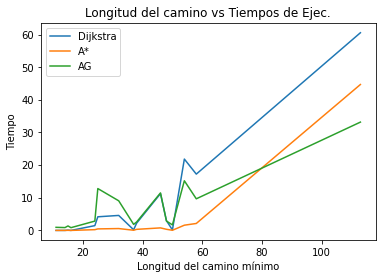

In [26]:
plt.plot(dic1.keys(), dic1.values(), label="Dijkstra")
plt.plot(dic2.keys(), dic2.values(), label="A*")
plt.plot(dic3.keys(), dic3.values(), label="AG")
plt.xlabel("Longitud del camino mínimo")
plt.ylabel("Tiempo")
plt.title("Longitud del camino vs Tiempos de Ejec.")
plt.legend()
plt.show()

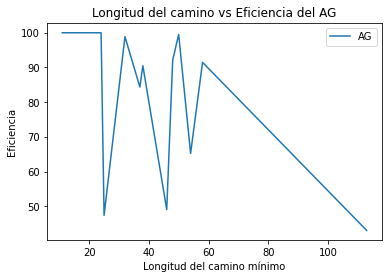

In [27]:
plt.plot(dic4.keys(), dic4.values(), label="AG")
plt.xlabel("Longitud del camino mínimo")
plt.ylabel("Eficiencia")
plt.title("Longitud del camino vs Eficiencia del AG")
plt.legend()
plt.show()